Discriminator evaluated on real data (left): 0.6936422
Discriminator evaluated on fake data (right): 0.21452211


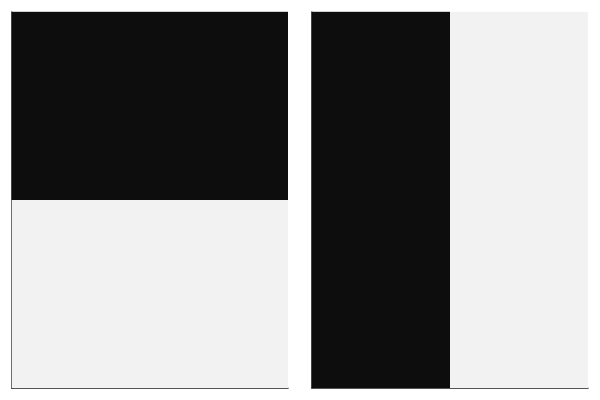

In [21]:
#Testing the Discriminator
using Flux
using JLD2
using Plots
using Yao, FLOYao
using LinearAlgebra
using BitBasis 

n = 2
nq = n^2
train = 100

function MyModel() #Need to change this part to fit the architecture of d
    return Chain(Dense(nq, 100, relu), Dense(100, 1, sigmoid))
end

model_state = JLD2.load("model.jld2", "model_state");
d = MyModel(); # MyModel definition must be available
Flux.loadmodel!(d, model_state)

function create_circuit(nq::Int)
    layers = 20 #Number of brick-wall layers in the circuit
    g = chain(nq)
    for _ in 1:layers
        for i in 1:2:nq-1
            push!(g, rot(kron(nq, i => X, i+1 => X), 0.)) #Nearest-neighbor XX rotation gates
        end
        for i in 2:2:nq-1
            push!(g, rot(kron(nq, i => X, i+1 => Y), 0.)) #Nearest-neighbor XY rotation gates
        end
        for i in 1:nq
            push!(g, put(nq, i => Rz(0.))) #Single qubit Z rotation gates
        end
    end
    return g
end

g = create_circuit(nq)
p = JLD2.load("gparams.jld2")
p = p["gparams"]
dispatch!(g, p)

data_train = JLD2.load("dataset.jld2")["data_train"]

function d_postprocess(measurement::Vector)
    l = length(measurement)
    aa = breflect.(measurement)
    ret = Matrix(undef, nq, l)
    for i in 1:l
        ret[:,i] = [aa[i]...]
    end
    return ret
end

samples = []
m = rand(1:train)
push!(samples, reshape(data_train[m],n,n))
println("Discriminator evaluated on real data (left): ", d(data_train[m] |> vec ) |> first)
fake = Int.(d_postprocess(measure(apply(FLOYao.zero_state(nq), g), nshots = 1)))
push!(samples, reshape(fake, n, n))
println("Discriminator evaluated on fake data (right): ", d(fake) |> first)
Plots.plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in samples]...)

Discriminator evaluated on custom data: 0.7885359
Probability that generator outputs this custom sample: 0.011495753842268388

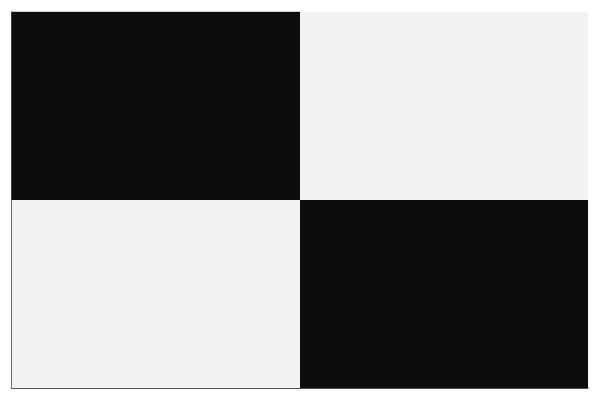

In [22]:
# Generator probabilities
using Plots
using Yao, FLOYao
using LinearAlgebra
using JLD2
using BitBasis 

custom = Bool[1 0; 0 1]

println("Discriminator evaluated on custom data: ", d(custom |> vec) |> first)
bitstr = BitStr(vec(Int.(custom)))
reg = apply(FLOYao.zero_state(nq), g)
print("Probability that generator outputs this custom sample: ", FLOYao.bitstring_probability(reg, bitstr))
Plots.plot(heatmap(custom, color=:grays, colorbar = false, ticks = false))